In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pulp
from sklearn.preprocessing import StandardScaler

In [2]:
biomass = pd.read_csv('./dataset/Biomass_History.csv')

In [3]:
dist_matrix = pd.read_csv('./dataset/Distance_Matrix.csv')

In [4]:
sample_submission = pd.read_csv('./dataset/sample_submission.csv')

In [5]:
biomass['2018'] = biomass.iloc[:,3:].mean(axis=1)

In [6]:
biomass['2018_norm'] = (biomass['2018'] - biomass['2018'].min())/biomass['2018'].max()

In [7]:
sum(biomass['2018'])/20000

17.072928963014427

In [8]:
biomass['Latitude'] = biomass.Latitude.astype('float')
biomass['Longitude'] = biomass.Longitude.astype('float')

In [9]:
biomass['2010'].sum()

349162.643347322

In [10]:
dist_matrix.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,2408,2409,2410,2411,2412,2413,2414,2415,2416,2417
0,0,0.0000,11.3769,20.4557,38.1227,45.3810,54.9915,78.6108,118.6750,102.6639,...,683.8771,687.6310,697.3246,669.3962,667.6788,665.5775,662.0291,665.9655,673.2073,681.4235
1,1,11.3769,0.0000,9.0788,28.9141,36.1724,45.7829,69.4022,78.2329,93.4553,...,681.6295,685.3833,695.0769,667.1485,665.4311,663.3298,659.7815,663.7178,670.9596,679.1758
2,2,20.4557,9.0788,0.0000,22.3791,29.6374,39.2478,62.8671,71.6979,86.9203,...,682.2323,685.9861,695.6796,667.7513,666.0339,663.9326,660.3843,664.3206,671.5623,679.7786
3,3,38.1227,28.9141,22.3791,0.0000,11.8343,23.5413,41.8396,50.6703,65.8927,...,681.4226,685.1765,694.8701,666.9417,665.2243,663.1230,659.5746,663.5110,670.7528,678.9690
4,4,45.3810,36.1724,29.6374,11.8343,0.0000,11.7070,24.3986,33.2293,53.9901,...,663.9816,667.7355,677.4291,649.5007,647.7833,645.6820,642.1336,646.0700,653.3118,661.5280


In [15]:
sample_submission['data_type'].unique()

array(['depot_location', 'refinery_location', 'biomass_forecast',
       'biomass_demand_supply', 'pellet_demand_supply'], dtype=object)

In [14]:
supply_2010 = biomass[['Latitude','Longitude','2010']]

## Visualize biomass sites

In [12]:
sns.scatterplot(x = supply_2010['Latitude'],y = supply_2010['Longitude'],hue=supply_2010['2010'])

KeyError: '2010'

In [ ]:
sns.scatterplot(x = supply_2010['Latitude'],y = supply_2010['Longitude'],hue=supply_2010['2011'])

In [ ]:
sns.scatterplot(x = supply_2010['Latitude'],y = supply_2010['Longitude'],hue=supply_2010['2012'])

In [ ]:
sns.scatterplot(x = supply_2010['Latitude'],y = supply_2010['Longitude'],hue=supply_2010['2013'])

In [ ]:
sns.scatterplot(x = supply_2010['Latitude'],y = supply_2010['Longitude'],hue=supply_2010['2014'])

In [ ]:
sns.scatterplot(x = supply_2010['Latitude'],y = supply_2010['Longitude'],hue=supply_2010['2015'])

In [ ]:
sns.scatterplot(x = supply_2010['Latitude'],y = supply_2010['Longitude'],hue=supply_2010['2016'])

In [ ]:
sns.scatterplot(x = supply_2010['Latitude'],y = supply_2010['Longitude'],hue=supply_2010['2017'])

In [ ]:
biomass.iloc[0,1:3][:]

## Selecting optimal location for depots

In [11]:
import random 
import scipy.spatial
from haversine import haversine


def distance(p1,p2):
  return haversine(p1[1:],p2[1:])

def cluster_centroids(data, clusters, k):
  results=[]
  for i in range(k):
    results.append( np.average(data[clusters == i],weights=np.squeeze(np.asarray(data[clusters == i][:,0:1])),axis=0))
  return results

def kmeans(data, k=None, centroids=None, steps=20):
  # Forgy initialization method: choose k data points randomly.
  centroids = data[np.random.choice(np.arange(len(data)), k, False)]
#   elbow = [] 
  for _ in range(max(steps, 1)):
    sqdists = scipy.spatial.distance.cdist(centroids, data, lambda u, v: distance(u,v)**2)
#     elbow.append(sqdists)
    # Index of the closest centroid to each data point.
    clusters = np.argmin(sqdists, axis=0)
    new_centroids = cluster_centroids(data, clusters, k)
    if np.array_equal(new_centroids, centroids):
      break
    centroids = new_centroids
  return clusters, centroids,sqdists

#setup

vals = biomass[['2018_norm','Latitude','Longitude']].values
k = 25
random.seed(42)
#run it
clusters = []
centroids = []
elbow = []
for i in range(18,k+1):
    clusters1,centroids1,elbow1=kmeans(vals,k=i)
    clusters.append(clusters1)
    centroids.append(centroids1)
    elbow.append(elbow1)
#output


In [20]:
len(clusters)

8

In [21]:
elbow_sse = [sum(i[0]) for i in elbow]

In [22]:
min_dict = {0:18,1:19,2:20,3:21,4:22,5:23,6:24,7:25}


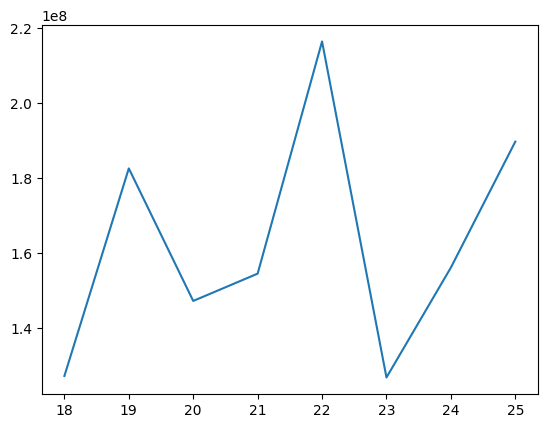

In [23]:
x = np.linspace(18,25,num = 8)
plt.plot(x,elbow_sse)

In [24]:
centroids[4][21][0]

0.3052233843850957

In [25]:
data_1 = pd.DataFrame()
k = min_dict[elbow_sse.index(min(elbow_sse))] 
data_1['c']=[int(c) for c in clusters[elbow_sse.index(min(elbow_sse))]]
lats = [centroids[elbow_sse.index(min(elbow_sse))][j][1] for j in range(k)]
data_1['clat'] = data_1['c'].map(lambda x: lats[x])
weights = [centroids[elbow_sse.index(min(elbow_sse))][j][0] for j in range(k)]
data_1['size'] = data_1['c'].map(lambda x: weights[x])
longs = [centroids[elbow_sse.index(min(elbow_sse))][j][2] for j in range(k)]
data_1['clong'] = data_1['c'].map(lambda x: longs[x])
# data.to_csv("clustered_us_census.csv", index=False)

In [ ]:
data_1['c'].unique()

In [26]:
lat_long = list(zip(list(biomass['Latitude']),list(biomass['Longitude'])))

In [27]:
lat_long2 = list(zip(list(data_1['clat'].unique()),list(data_1['clong'].unique())))

In [28]:
def distance(p1,p2):
  return haversine(p1[1:],p2[1:])

def compare_lists(list1,list2):
    depots = []
    for i in range(len(list1)):
        dist = []
        for j in range(len(list2)):
            dist.append(haversine(list1[i],list2[j]))
        depots.append(dist.index(min(dist)))
    return depots
            

In [29]:
depots = compare_lists(lat_long2,lat_long)

In [30]:
data_2 = data.iloc[depots,:].reset_index()

NameError: name 'data' is not defined

In [ ]:
20000*18/100000

In [ ]:
sns.scatterplot(x = biomass['Latitude'],y = biomass['Longitude'],hue=biomass['2018'])

In [ ]:
sns.scatterplot(x = data['clat'],y = data['clong'],hue=data['c'],size = data['size'])

In [ ]:
data_2

## Selecting optimal number of refineries

In [ ]:
import random 
import scipy.spatial
from haversine import haversine


def distance(p1,p2):
  return haversine(p1[1:],p2[1:])

def cluster_centroids(data, clusters, k):
  results=[]
  for i in range(k):
    results.append( np.average(data[clusters == i],weights=np.squeeze(np.asarray(data[clusters == i][:,0:1])),axis=0))
  return results

def kmeans(data, k=None, centroids=None, steps=20):
  # Forgy initialization method: choose k data points randomly.
  centroids = data[np.random.choice(np.arange(len(data)), k, False)]
#   elbow = [] 
  for _ in range(max(steps, 1)):
    sqdists = scipy.spatial.distance.cdist(centroids, data, lambda u, v: distance(u,v)**2)
#     elbow.append(sqdists)
    # Index of the closest centroid to each data point.
    clusters = np.argmin(sqdists, axis=0)
    new_centroids = cluster_centroids(data, clusters, k)
    if np.array_equal(new_centroids, centroids):
      break
    centroids = new_centroids
  return clusters, centroids,sqdists

#setup

vals = data_2[['size','clat','clong']].values
k = 5
random.seed(42)
#run it
clusters = []
centroids = []
elbow = []
for i in range(3,k+1):
    clusters1,centroids1,elbow1=kmeans(vals,k=i)
    clusters.append(clusters1)
    centroids.append(centroids1)
    elbow.append(elbow1)

In [ ]:
elbow_sse = [sum(i[0]) for i in elbow]

In [ ]:
x = np.linspace(3,5,num = 3)
plt.plot(x,elbow_sse)

In [ ]:
centroids[1]

In [ ]:
data_refinery = pd.DataFrame()

data_refinery['c']=[int(c) for c in clusters[1]]
lats = [centroids[2][j][1] for j in range(4)]
data_refinery['clat'] = data_refinery['c'].map(lambda x: lats[x])
weights = [centroids[1][j][0] for j in range(4)]
data_refinery['size'] = data_refinery['c'].map(lambda x: weights[x])
longs = [centroids[1][j][2] for j in range(4)]
data_refinery['clong'] = data_refinery['c'].map(lambda x: longs[x])

In [ ]:
data_refinery

In [ ]:
lat_long_refinery = list(zip(list(data_refinery['clat'].unique()),list(data_refinery['clong'].unique())))

In [ ]:
refinery = compare_lists(lat_long_refinery,lat_long)

In [ ]:
refinery

In [ ]:
biomass['site'] = 'harvest'

In [ ]:
biomass.iloc[depots,-1] = 'depot'
biomass.iloc[refinery,-1] = 'refinery'

In [ ]:
depots

In [ ]:
biomass

In [ ]:
biomass_cost_arr = np.zeros((2418,22))
for i in range(2418):
    for j in range(22):
        biomass_cost_arr[i,j] = dist_matrix.iloc[i,depots[j]]
        

In [ ]:
biomass_cost_arr

In [ ]:
refinery_cost_arr = np.zeros((22,4))
for i in range(22):
    for j in range(4):
        refinery_cost_arr[i,j] = dist_matrix.iloc[depots[i],refinery[j]]

## Transport cost model

In [210]:
from pyscipopt import Model,quicksum,multidict

In [232]:
d = {}
M = {}
I = {}
J = {}
c = {}
for i in range(len(biomass.index)):
    d[i] = biomass.loc[i,'2018']

for i in range(22):
    M[i] = 20000

I =list(np.arange(0,2418))
J = list(np.arange(0,22))

for i in range(biomass_cost_arr.shape[0]):
    for j in range(biomass_cost_arr.shape[1]):
        c[(i,j)] = biomass_cost_arr[i,j]


In [233]:
model = Model("transportation")
x = {}
for i in I:
    for j in J:
        x[i,j] = model.addVar(vtype="C", name="x(%s,%s)" % (i,j))

In [234]:
for i in I:
    model.addCons(quicksum(x[i,j] for j in J if (i,j) in x) == d[i], name="Demand(%s)" % i)


In [235]:
for j in J:
    model.addCons(quicksum(x[i,j] for i in I if (i,j) in x) <= M[j], name="Capacity(%s)" % j)


In [236]:
model.setObjective(quicksum(c[i,j]*x[i,j]  for (i,j) in x), "minimize")

In [237]:
model.optimize()
print("Optimal value:", model.getObjVal())
EPS = 1.e-6
for (i,j) in x:
    if model.getVal(x[i,j]) > EPS:
        print("sending quantity %10s from factory %3s to customer %3s" % (model.getVal(x[i,j]),j,i))


presolving:
(round 1, fast)       0 del vars, 0 del conss, 0 add conss, 53196 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
   (0.7s) running MILP presolver
   (0.8s) MILP presolver found nothing
presolving (2 rounds: 2 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 53196 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 53196 variables (0 bin, 0 int, 0 impl, 53196 cont) and 2440 constraints
   2440 constraints of type <linear>
Presolving Time: 1.35

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  dualbound   | primalbound  |  gap   | compl. 
* 2.8s|     1 |     0 |  2482 |     - |    LP  |   0 |  53k|2440 |2440 |   0 |  0 |   0 |   0 | 1.533688e+07 | 1.533688e+07 |   0.00%| unknown
  2.8s|     1 |     0 |  2482 |     - |   214M |   0 |  53k|2440 |2440 |   0 |  0 |   0 |   0 | 1.533688e+07 | 1.533688

In [ ]:
d = {}
M = {}
I = {}
J = {}
c = {}
for i in range(len(biomass.index)):
    d[i] = biomass.loc[i,'2018']

for i in range(22):
    M[i] = 20000

I =list(np.arange(0,2418))
J = list(np.arange(0,22))

for i in range(biomass_cost_arr.shape[0]):
    for j in range(biomass_cost_arr.shape[1]):
        c[(i,j)] = biomass_cost_arr[i,j]

In [ ]:
model_refinery = Model('transportation')


In [ ]:
def flp(I,J,d,M,f,c):
    model = Model("flp")
    x,y = {},{}
    for j in J:
        y[j] = model.addVar(vtype="B", name="y(%s)"%j)
        for i in I:
            x[i,j] = model.addVar(vtype="C", name="x(%s,%s)"%(i,j))
    for i in I:
        model.addCons(quicksum(x[i,j] for j in J) == d[i], "Demand(%s)"%i)
    for j in M:
        model.addCons(quicksum(x[i,j] for i in I) <= M[j]*y[j], "Capacity(%s)"%i)
    for (i,j) in x:
        model.addCons(x[i,j] <= d[i]*y[j], "Strong(%s,%s)"%(i,j))
    model.setObjective(
        quicksum(f[j]*y[j] for j in J) +
        quicksum(c[i,j]*x[i,j] for i in I for j in J),
        "minimize")
    model.data = x,y
    return model

In [ ]:
 I, d = multidict({1:80, 2:270, 3:250, 4:160, 5:180})
 J, M, f = multidict({1:[500,1000], 2:[500,1000], 3:[500,1000]})
 c = {(1,1):4,  (1,2):6,  (1,3):9,
      (2,1):5,  (2,2):4,  (2,3):7,
      (3,1):6,  (3,2):3,  (3,3):4,
      (4,1):8,  (4,2):5,  (4,3):3,
      (5,1):10, (5,2):8,  (5,3):4,
      }

In [ ]:
 model = flp(I, J, d, M, f, c)
 model.optimize()
 EPS = 1.e-6
 x,y = model.__data
 edges = [(i,j) for (i,j) in x if model.GetVal(x[i,j]) > EPS]
 facilities = [j for j in y if model.GetVal(y[j]) > EPS]
 print "Optimal value=", model.GetObjVal()
 print "Facilities at nodes:", facilities
 print "Edges:", edges

In [66]:
import pulp

In [68]:
np.arange(2418)

array([   0,    1,    2, ..., 2415, 2416, 2417])

In [70]:
sites = list(np.arange(2418))
sites

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [71]:
biomass_supply = dict(zip(sites,biomass['2010']))

In [72]:
biomass_supply

{0: 8.475744247,
 1: 24.02977753,
 2: 44.83163452,
 3: 59.97441864,
 4: 14.6533699,
 5: 17.41663933,
 6: 23.56865692,
 7: 48.34523392,
 8: 58.78428268,
 9: 67.90737915,
 10: 8.916523933,
 11: 3.416373968,
 12: 2.298105955,
 13: 0.405263782,
 14: 0.378063947,
 15: 45.17411041,
 16: 56.53974152,
 17: 139.3889465,
 18: 140.0259857,
 19: 51.76260757,
 20: 61.17729568,
 21: 84.54468536,
 22: 99.1736145,
 23: 150.2328644,
 24: 144.6105194,
 25: 45.69966888,
 26: 24.97690392,
 27: 19.92323303,
 28: 6.596181393,
 29: 0.14898251,
 30: 33.44884491,
 31: 65.62121582,
 32: 121.0332336,
 33: 117.2946014,
 34: 121.5485306,
 35: 102.3113708,
 36: 136.3761597,
 37: 141.9011383,
 38: 77.37073517,
 39: 54.08869171,
 40: 44.4982605,
 41: 53.13540268,
 42: 75.98052216,
 43: 30.84760094,
 44: 1.716194034,
 45: 0.40073213,
 46: 1.185710669,
 47: 9.411384583,
 48: 53.4867363,
 49: 67.84522247,
 50: 92.29341125,
 51: 107.6716156,
 52: 83.22322083,
 53: 99.09132385,
 54: 127.3641663,
 55: 134.515976,
 56: 134.

In [ ]:
biomass_demand()